## Airbnb Data Cleaning

Liqin Zhang - lz2809

In [3]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
print('all import succeed')

all import succeed
all import succeed


In [4]:
raw_df = pd.read_csv('/Users/liqin/Downloads/nyc_listing.csv')
print(f"Import {len(raw_df)} Airbnb listings")

Import 37713 Airbnb listings


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20211102175544,2021-11-03,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,a few days or more,35%,18%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,8.0,8.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,NaN,1 bath,NaN,1.0,"[""Bathtub"", ""Dedicated workspace"", ""Hair dryer...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,17,47,322,2021-11-03,48,0,0,2009-11-21,2019-11-04,4.70,4.72,4.62,4.76,4.79,4.86,4.41,NaN,f,3,3,0,0,0.33
1,3831,https://www.airbnb.com/rooms/3831,20211102175544,2021-11-03,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,a few days or more,21%,76%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Brooklyn, New York, United States",Bedford-Stuyvesant,Brooklyn,40.68494,-73.95765,Entire guest suite,Entire home/apt,3,NaN,1 bath,1.0,3.0,"[""Microwave"", ""Oven"", ""Pack \u2019n play/Trave...",$73.00,1,730,1.0,1.0,730.0,730.0,1.0,730.0,NaN,t,4,10,33,220,2021-11-03,408,38,0,2015-01-05,2021-06-29,4.46,4.59,4.50,4.79,4.81,4.72,4.65,NaN,f,1,1,0,0,4.91
2,5121,https://www.airbnb.com/rooms/5121,20211102175544,2021-11-03,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",within a few hours,100%,100%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,Private room,2,NaN,NaN,1.0,1.0,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",$60.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN

### Drop unused feature columns

In [6]:
drop_features = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(drop_features, axis=1)

In [7]:
df.isna().sum()

id                                                  0
host_since                                         31
host_response_time                              17058
host_response_rate                              17058
host_acceptance_rate                            16354
host_is_superhost                                  31
host_listings_count                                31
host_total_listings_count                          31
host_has_profile_pic                               31
host_identity_verified                             31
neighbourhood                                   15206
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

In [8]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)
df.set_index('id', inplace=True) 

In [9]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

31


,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2835711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, United States",Greenwich Village,40.73058,-74.00070,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Stove"", ""Dedicated workspace"", ""Hair dryer"",...",$106.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,10,12,16,169,48,4,0,2018-11-24,2021-07-31,4.46,4.63,3.75,4.85,4.92,4.92,4.52,f,1,1,0,0,1.34
4446862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Crown Heights,40.67605,-73.95997,Private room in rental unit,Private room,2,NaN,1 bath,1.0,1.0,"[""Long term stays allowed"", ""TV"", ""Heating"", ""...",$50.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4763327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Greenpoint,40.72119,-73.95279,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Long term stays allowed"", ""Cable TV"", ""Hot t...",$195.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,1,0,0,2015-10-20,2015-10-20,4.00,4.00,5.00,5.00,4.00,5.00,4.00,f,1,1,0,0,0.01
6360224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bushwick,40.69977,-73.92912,Private room in rental unit,Private room,1,NaN,0 baths,1.0,1.0,"[""Long term stays allowed"", ""Heating"", ""Wifi"",...",$37.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,1,0,0,2015-07-01,2015-07-01,0.00,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,0.01
6992973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, New York, United States",Williamsburg,40.71944,-73.95645,Entire rental unit,Entire home/apt,4,NaN,2 baths,2.0,1.0,"[""Long term stays allowed"", ""Shampoo"", ""Fire e...",$145.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [10]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


In [11]:
lat_long = df[['latitude', 'longitude']]

In [12]:
df.drop(['latitude', 'longitude', 'neighbourhood'], axis=1, inplace=True)

In [13]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1520

In [14]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

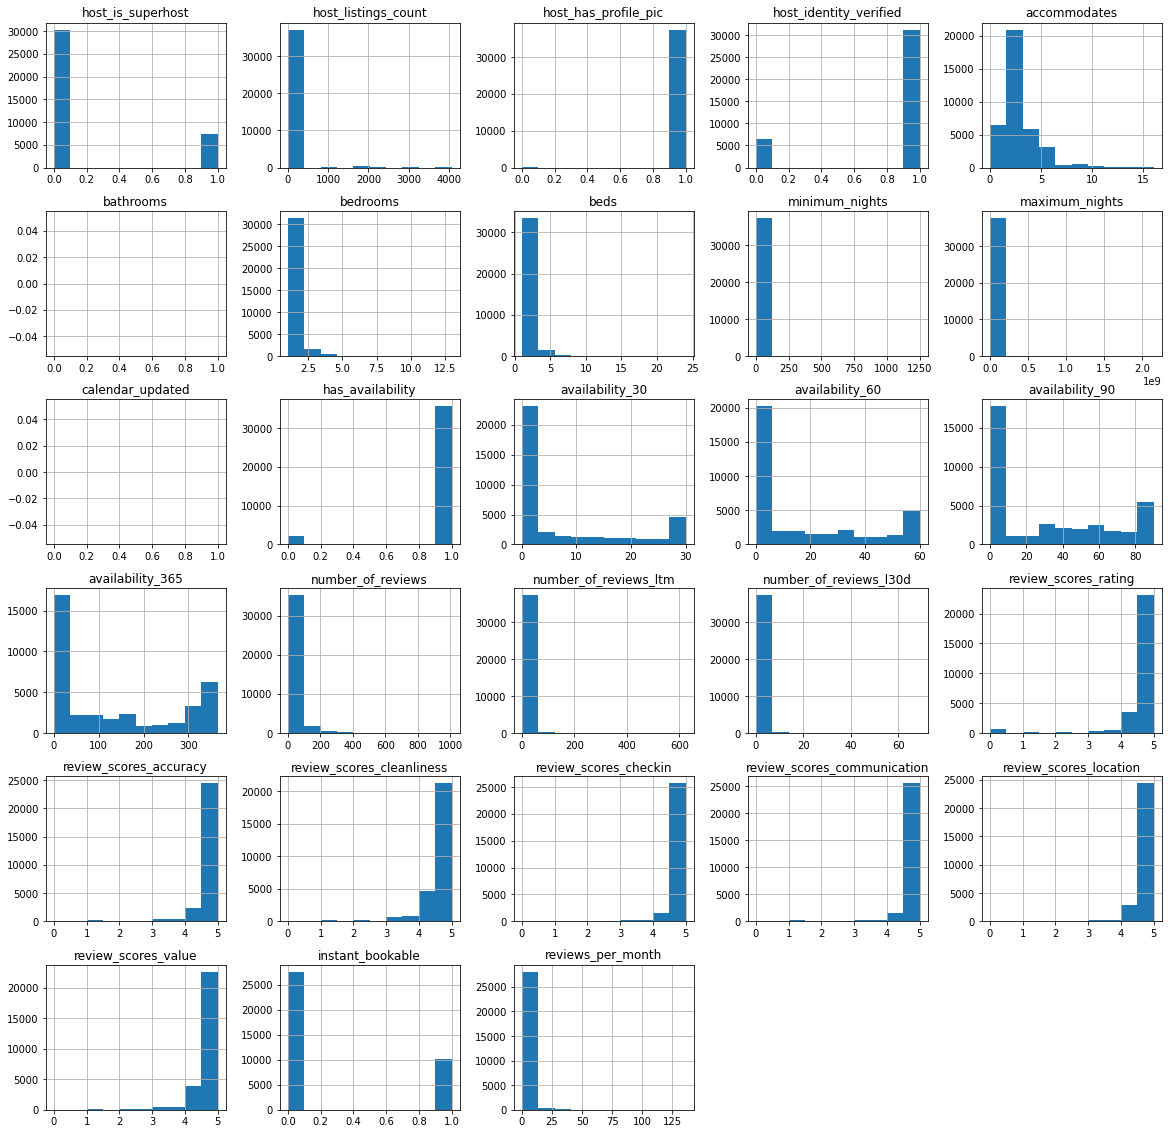

In [15]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to - message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Clean specific columns


In [16]:
df.amenities[:1].values

array(['["Bathtub", "Dedicated workspace", "Hair dryer", "Fire extinguisher", "TV", "Carbon monoxide alarm", "Dishes and silverware", "Keypad", "Free street parking", "Hot water", "Essentials", "Paid parking off premises", "Luggage dropoff allowed", "Ethernet connection", "Long term stays allowed", "Cleaning before checkout", "Smoke alarm", "Kitchen", "Refrigerator", "Cooking basics", "Coffee maker", "Bed linens", "Stove", "Hangers", "Oven", "Iron", "Wifi", "Extra pillows and blankets", "Air conditioning", "Baking sheet", "Heating"]'],
      dtype=object)

In [17]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [18]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [19]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('] [', '')
amenities_list_string = amenities_list_string.replace('\\', '')
amenities_list_string = amenities_list_string.replace(' u2013', '')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'Google Home sound system',
 'DOVE  body soap',
 'LockboxPack u2019n play/Travel crib',
 'Generic  shampoo',
 'Dial body soap',
 'Products from ECO Sciences body soap',
 'WasherTrash compactor',
 'samsung sound system',
 'IronBed linens',
 'Game consoleMicrowave',
 'HeatingBody soap',
 'First aid kitIndoor fireplace',
 'Power Airfryer 360 stainless steel oven',
 'Amanna  oven',
 'KitchenTrash compactor',
 'TV with standard cableHot water kettle',
 'Onsite rooftop bar u2014 Make Believe',
 'bar soap  body soap',
 'Electric stoveLong term stays allowed',
 'HeatingDedicated workspace: desk',
 '36 HDTV with standard cableHeating',
 'Air conditioningLong term stays allowedLong term stays allowed',
 'samsung stainless steel oven',
 'Stainless steel oven',
 'Air conditioningOven',
 'First aid kitTV',
 "Johnson's conditioner",
 'Bang & Olufsen + Google Speakers sound system with Bluetooth and aux',
 'LG stainless steel oven',
 'Viking gas stove',
 'Wifi 160 Mbps',
 'Hard wired Bluetooth with 

In [20]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/var/folders/yj/_63z7pg17ln8p39zw_yh_lsh0000gn/T/ipykernel_27398/1151268171.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1


In [21]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'breakfast', 'child_friendly', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


In [22]:
df.columns[40:]

Index(['bed_linen', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'gym', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'private_entrance'],
      dtype='object')

In [23]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [24]:
df.drop('calendar_updated', axis=1, inplace=True)

In [25]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [26]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 24.4%
Null values in 'review_scores_rating': 24.4%


In [27]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

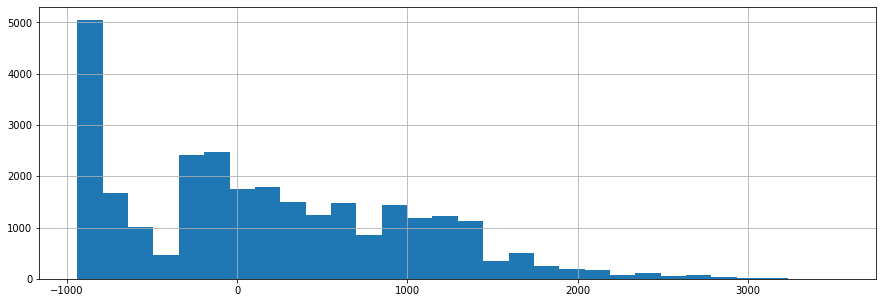

In [28]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [29]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [30]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [31]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

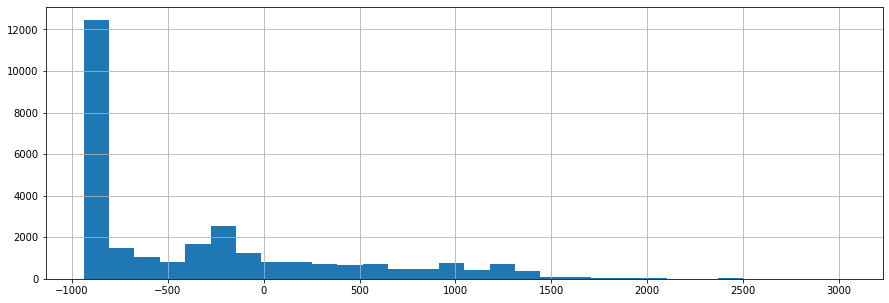

In [32]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [33]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [34]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

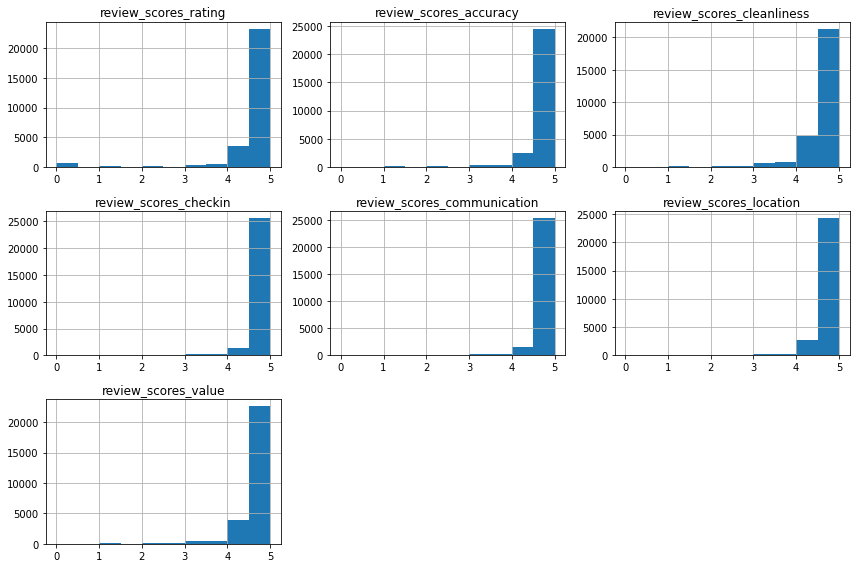

In [35]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [36]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [37]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [38]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

## Time series data analysis

In [39]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [40]:
ts_host_since = pd.DataFrame(df.set_index('host_since'))

In [41]:
ts_first_review = pd.DataFrame(df.set_index('first_review'))

In [42]:
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [43]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]


,host_since,host_listings_count
id,,
11866751,2015-03-30,401.0
19153081,2015-04-14,512.0
6117496,2015-04-07,653.0
38236827,2015-11-02,1106.0
50595904,2020-07-29,1185.0
52229417,2016-12-16,1987.0
51750623,2020-09-23,2232.0
52534282,2013-03-25,3139.0
51500571,2018-11-21,4067.0


/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


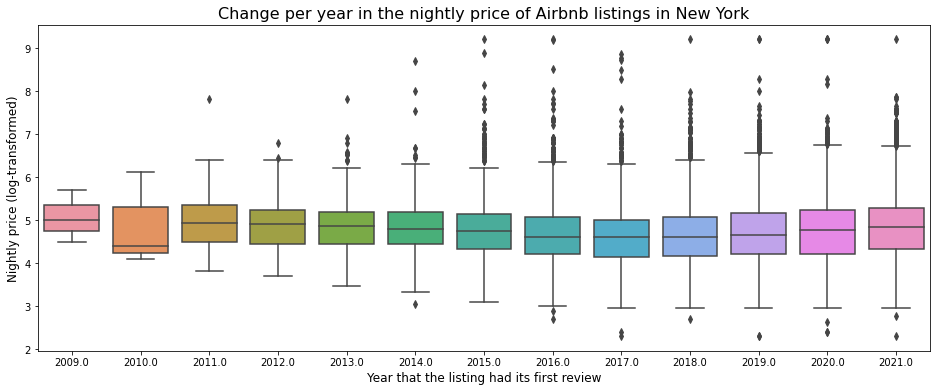

In [44]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in New York', fontsize=16)
plt.show()

In [45]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
11866751,2015-03-30,401.0
19153081,2015-04-14,512.0
6117496,2015-04-07,653.0
38236827,2015-11-02,1106.0
50595904,2020-07-29,1185.0
52229417,2016-12-16,1987.0
51750623,2020-09-23,2232.0
52534282,2013-03-25,3139.0
51500571,2018-11-21,4067.0


In [46]:
print("Mean nightly price of listings in each year on Airbnb in New York:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in New York:
first_review
2009-01-01    179.33
2010-01-01    153.71
2011-01-01    196.13
2012-01-01    157.71
2013-01-01    167.46
2014-01-01    155.07
2015-01-01    155.75
2016-01-01    146.02
2017-01-01    136.75
2018-01-01    142.60
2019-01-01    152.28
2020-01-01    177.91
2021-01-01    168.82
Name: price, dtype: float64


In [47]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [48]:
df.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,reviews_per_month,check_in_24h,air_conditioning,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,internet,long_term_stays,private_entrance
count,37682.000000,37682.000000,37682.000000,37682.000000,37713.000000,0.0,37713.000000,37713.000000,37713.000000,37713.000000,3.771300e+04,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,28501.000000,0.0,31460.0,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000,37713.000000
mean,0.195133,44.408471,0.993498,0.829972,2.784981,NaN,1.287116,1.555511,165.422560,22.130645,5.866011e+04,0.943468,30.737173,23.233368,4.675576,0.526954,0.268846,1.640820,NaN,1.0,0.375282,0.725559,0.368467,0.444011,0.460345,0.240156,0.105879,0.448148,0.122637,0.972927,0.918224,0.244796
std,0.396308,294.251560,0.080372,0.375662,1.863980,NaN,0.671743,1.054040,292.366182,30.809556,1.105915e+07,0.230950,33.750825,50.153962,14.257903,1.484155,0.443366,4.220807,NaN,0.0,0.484202,0.446238,0.482395,0.496862,0.498432,0.427184,0.307686,0.497311,0.328024,0.162298,0.274026,0.429972
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,69.000000,3.000000,6.000000e+01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.120000,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,2.000000,NaN,1.000000,1.000000,110.000000,30.000000,1.125000e+03,1.000000,18.000000,4.000000,0.000000,0.000000,0.000000,0.470000,NaN,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,4.000000,NaN,1.000000,2.000000,180.000000,30.000000,1.125000e+03,1.000000,61.000000,20.000000,3.000000,0.000000,1.000000,1.690000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,4067.000000,1.000000,1.000000,16.000000,NaN,13.000000,24.000000,10000.000000,1250.000000,2.147484e+09,1.000000,90.000000,1009.000000,624.000000,69.000000,1.000000,136.000000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


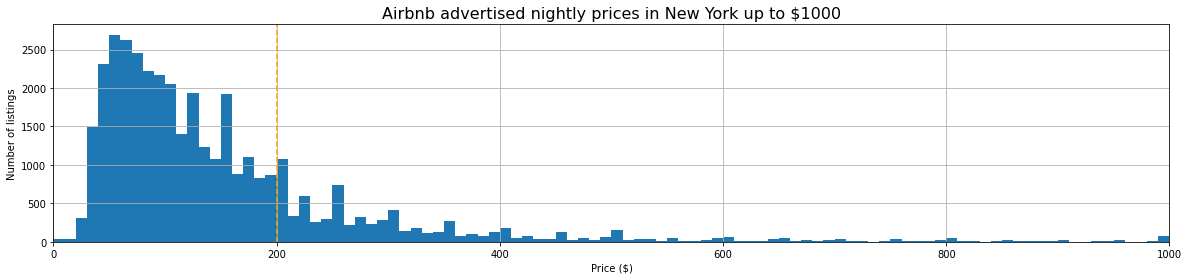

In [49]:
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in New York up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [50]:
df.loc[df.price <= 10, 'price'] = 10
df.loc[df.price >= 1000, 'price'] = 1000

In [51]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 44
45% of listings are from hosts with one listing.


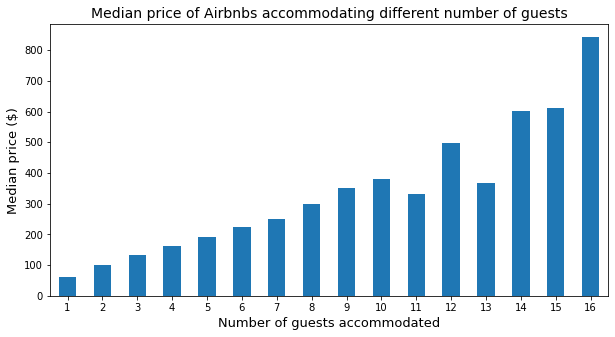

In [52]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

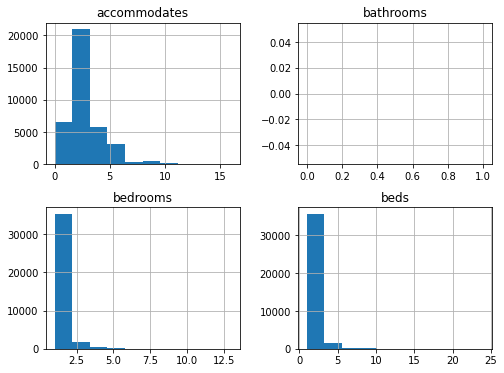

In [53]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

## Modeling

In [54]:
transformed_df = pd.get_dummies(df)

In [55]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

/var/folders/yj/_63z7pg17ln8p39zw_yh_lsh0000gn/T/ipykernel_27398/966998409.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


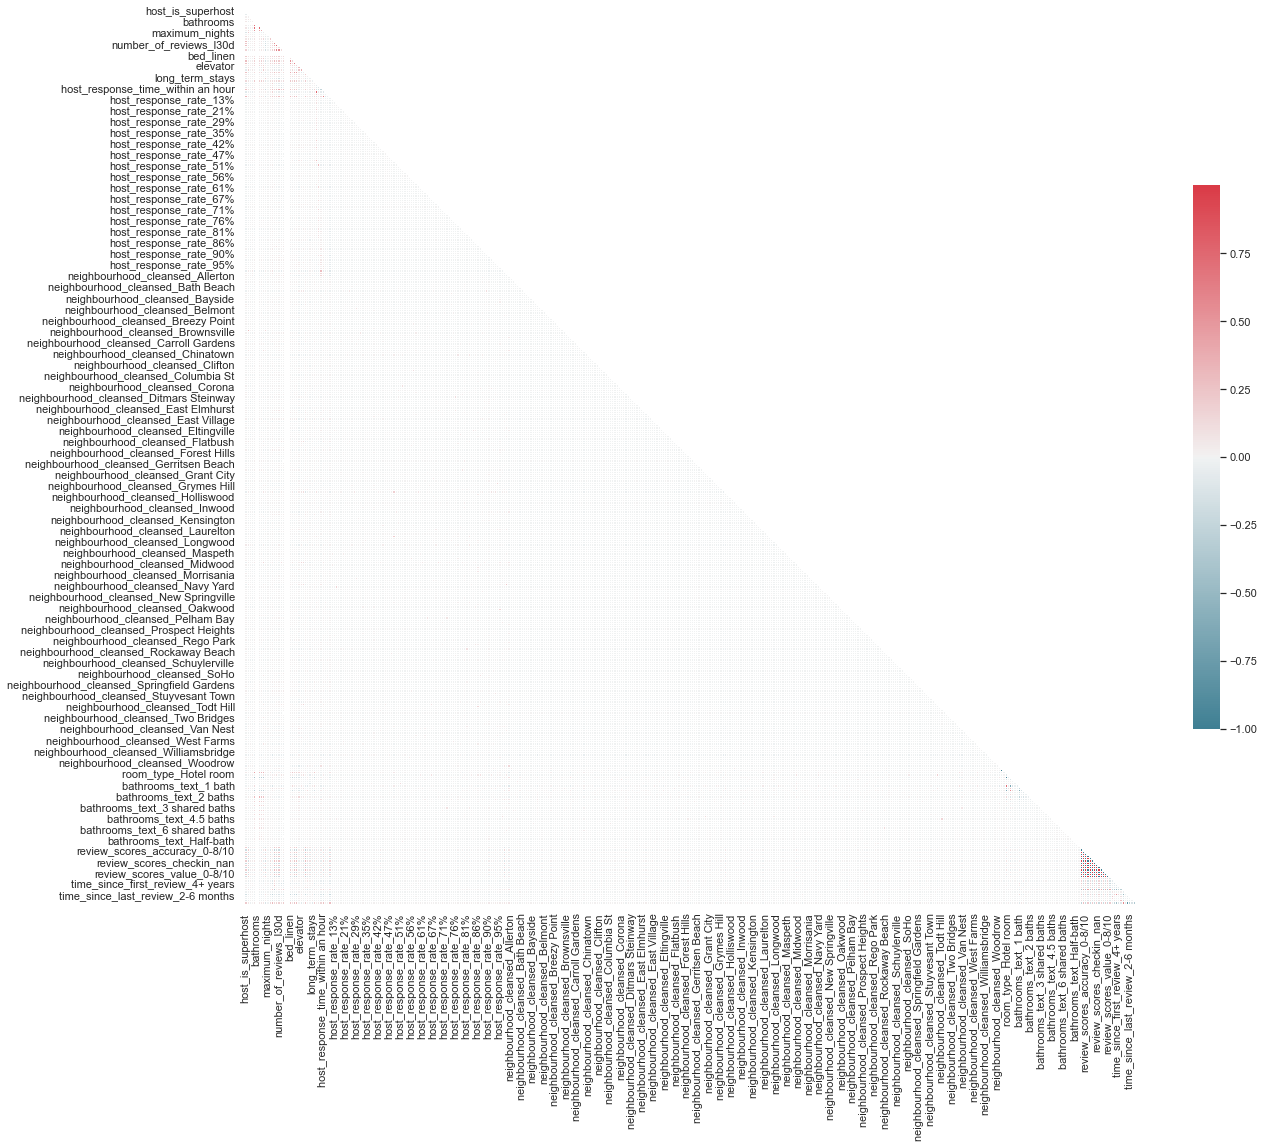

In [56]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

/var/folders/yj/_63z7pg17ln8p39zw_yh_lsh0000gn/T/ipykernel_27398/966998409.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


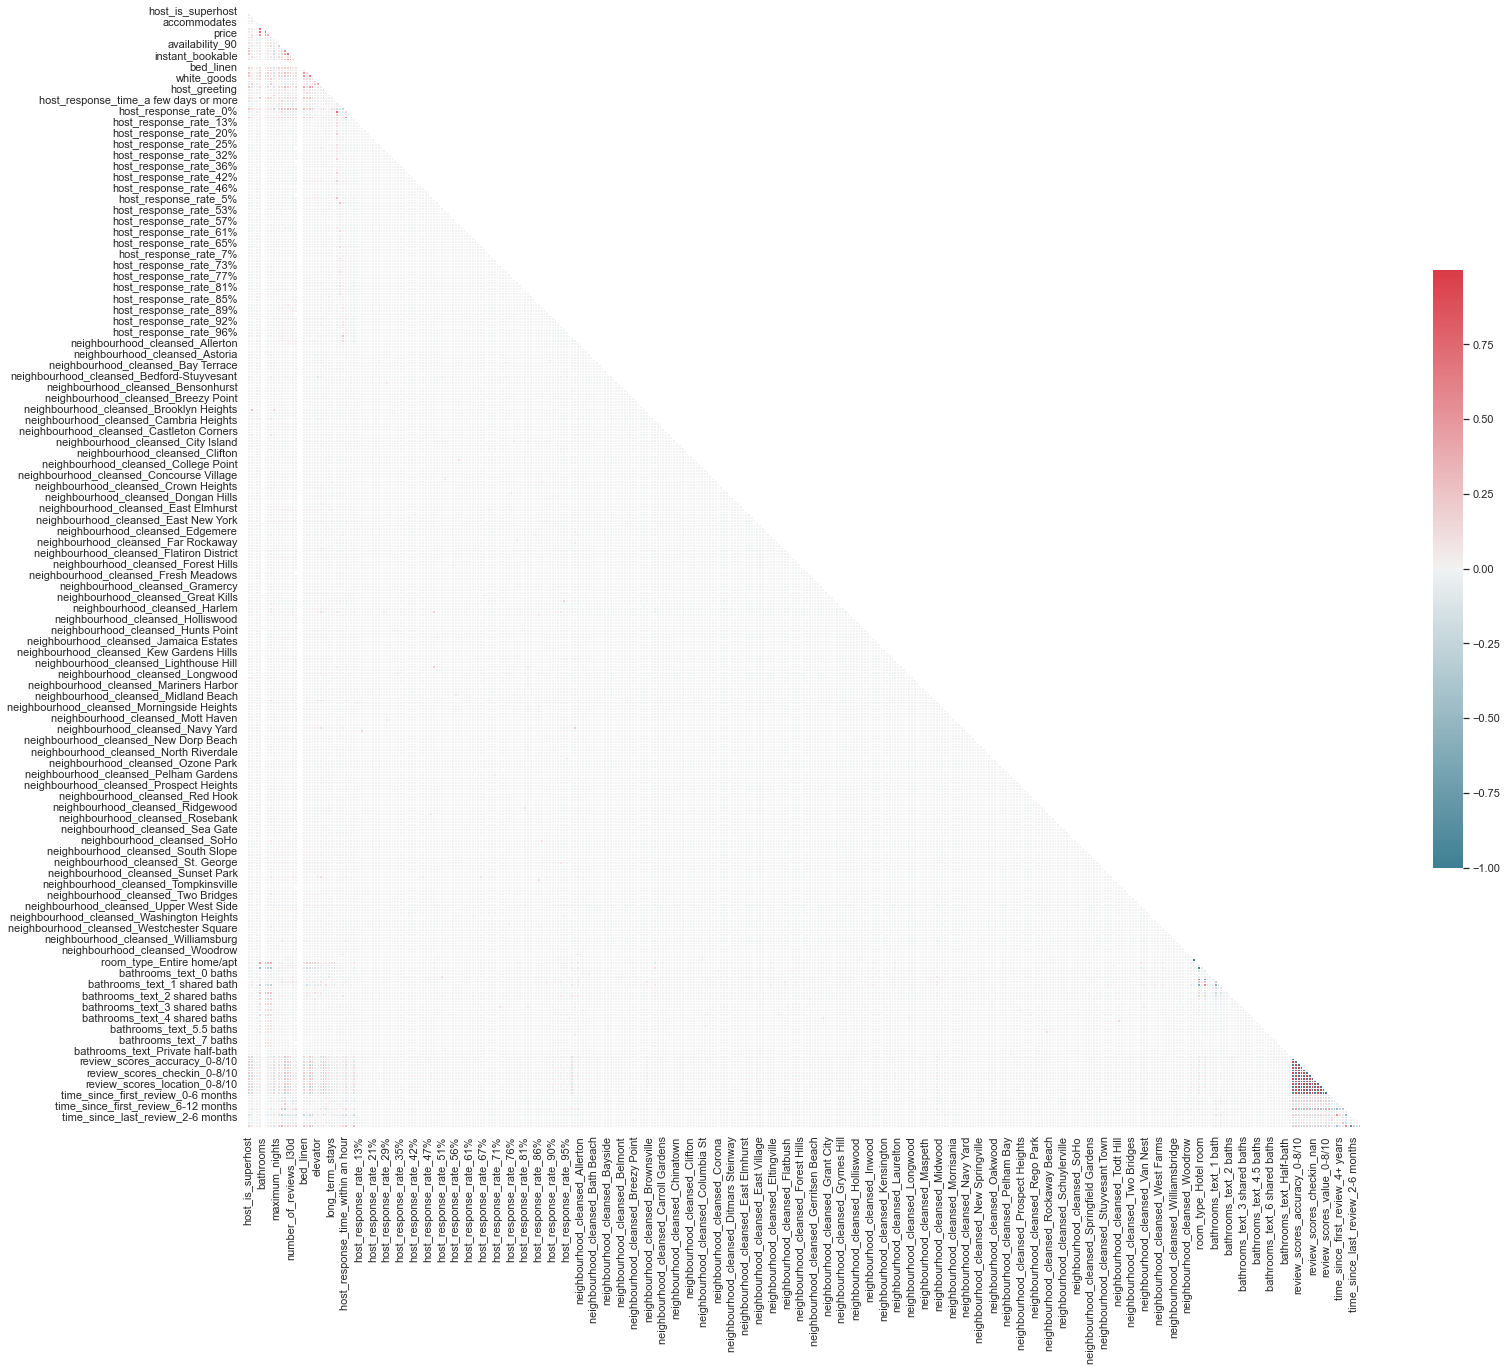

In [57]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [58]:
# Dropping collinear features
to_drop = ['host_response_rate_11%', 'host_response_rate_13%', 'host_response_rate_14%', 'host_response_rate_15%', 
           'host_response_rate_17%', 'host_response_rate_20%', 'host_response_rate_21%', 'host_response_rate_22%', 
           'host_response_rate_23%', 'host_response_rate_25%', 'host_response_rate_28%', 'host_response_rate_29%', 
           'host_response_rate_30%', 'host_response_rate_32%', 'host_response_rate_33%', 'host_response_rate_34%', 
           'host_response_rate_35%', 'host_response_rate_36%', 'host_response_rate_38%', 'host_response_rate_40%', 
           'host_response_rate_41%', 'host_response_rate_42%', 'host_response_rate_43%', 'host_response_rate_44%', 
           'host_response_rate_45%', 'host_response_rate_46%', 'host_response_rate_47%', 'host_response_rate_48%', 
           'host_response_rate_49%', 'host_response_rate_5%', 'host_response_rate_50%', 'host_response_rate_51%', 
           'host_response_rate_52%', 'host_response_rate_53%', 'host_response_rate_54%', 'host_response_rate_55%', 
           'host_response_rate_56%', 'host_response_rate_57%', 'host_response_rate_58%', 'host_response_rate_6%', 
           'host_response_rate_60%', 'host_response_rate_61%', 'host_response_rate_62%', 'host_response_rate_63%', 
           'host_response_rate_64%', 'host_response_rate_65%', 'host_response_rate_67%', 'host_response_rate_68%', 
           'host_response_rate_69%', 'host_response_rate_7%', 'host_response_rate_70%', 'host_response_rate_71%', 
           'host_response_rate_72%', 'host_response_rate_73%', 'host_response_rate_74%', 'host_response_rate_75%', 
           'host_response_rate_76%', 'host_response_rate_77%', 'host_response_rate_78%', 'host_response_rate_79%', 
           'host_response_rate_80%', 'host_response_rate_81%', 'host_response_rate_82%', 'host_response_rate_83%', 
           'host_response_rate_84%', 'host_response_rate_85%', 'host_response_rate_86%', 'host_response_rate_87%', 
           'host_response_rate_88%', 'host_response_rate_89%', 'host_response_rate_9%', 'host_response_rate_90%', 
           'host_response_rate_91%', 'host_response_rate_92%', 'host_response_rate_93%', 'host_response_rate_94%', 
           'host_response_rate_95%', 'host_response_rate_96%', 'host_response_rate_97%', 'host_response_rate_98%', 
           'host_response_rate_99%', 'neighbourhood_cleansed_Allerton', 'neighbourhood_cleansed_Arden Heights', 
           'neighbourhood_cleansed_Arrochar', 'neighbourhood_cleansed_Arverne', 'neighbourhood_cleansed_Astoria', 
           'neighbourhood_cleansed_Bath Beach', 'neighbourhood_cleansed_Battery Park City', 
           'neighbourhood_cleansed_Bay Ridge', 'neighbourhood_cleansed_Bay Terrace', 
           'neighbourhood_cleansed_Baychester', 'neighbourhood_cleansed_Bayside', 'neighbourhood_cleansed_Bayswater', 
           'neighbourhood_cleansed_Bedford-Stuyvesant', 'neighbourhood_cleansed_Belle Harbor', 
           'neighbourhood_cleansed_Bellerose', 'neighbourhood_cleansed_Belmont', 'neighbourhood_cleansed_Bensonhurst',
           'neighbourhood_cleansed_Bergen Beach', 'neighbourhood_cleansed_Boerum Hill', 
           'neighbourhood_cleansed_Borough Park', 'neighbourhood_cleansed_Breezy Point',
           'neighbourhood_cleansed_Briarwood', 'neighbourhood_cleansed_Brighton Beach', 
           'neighbourhood_cleansed_Bronxdale', 'neighbourhood_cleansed_Brooklyn Heights', 
           'neighbourhood_cleansed_Brownsville', "neighbourhood_cleansed_Bull's Head", 
           'neighbourhood_cleansed_Bushwick', 'neighbourhood_cleansed_Cambria Heights', 'neighbourhood_cleansed_Canarsie', 'neighbourhood_cleansed_Carroll Gardens', 'neighbourhood_cleansed_Castle Hill',
           'neighbourhood_cleansed_Castleton Corners', 'neighbourhood_cleansed_Chelsea', 'neighbourhood_cleansed_Chelsea, Staten Island', 'neighbourhood_cleansed_Chinatown', 'neighbourhood_cleansed_City Island', 'neighbourhood_cleansed_Civic Center', 'neighbourhood_cleansed_Claremont Village', 
           'neighbourhood_cleansed_Clason Point', 'neighbourhood_cleansed_Clifton', 'neighbourhood_cleansed_Clinton Hill', 'neighbourhood_cleansed_Co-op City', 'neighbourhood_cleansed_Cobble Hill', 'neighbourhood_cleansed_College Point', 'neighbourhood_cleansed_Columbia St', 'neighbourhood_cleansed_Concord', 'neighbourhood_cleansed_Concourse', 
           'neighbourhood_cleansed_Concourse Village', 'neighbourhood_cleansed_Coney Island', 'neighbourhood_cleansed_Corona', 'neighbourhood_cleansed_Country Club', 'neighbourhood_cleansed_Crown Heights', 'neighbourhood_cleansed_Cypress Hills', 'neighbourhood_cleansed_DUMBO', 'neighbourhood_cleansed_Ditmars Steinway',
           'neighbourhood_cleansed_Dongan Hills', 'neighbourhood_cleansed_Douglaston', 'neighbourhood_cleansed_Downtown Brooklyn', 'neighbourhood_cleansed_Dyker Heights', 'neighbourhood_cleansed_East Elmhurst', 'neighbourhood_cleansed_East Flatbush', 'neighbourhood_cleansed_East Harlem', 'neighbourhood_cleansed_East Morrisania', 'neighbourhood_cleansed_East New York', 'neighbourhood_cleansed_East Village', 
           'neighbourhood_cleansed_Eastchester', 'neighbourhood_cleansed_Edenwald', 'neighbourhood_cleansed_Edgemere', 'neighbourhood_cleansed_Elmhurst', 'neighbourhood_cleansed_Eltingville', 'neighbourhood_cleansed_Emerson Hill', 'neighbourhood_cleansed_Far Rockaway', 'neighbourhood_cleansed_Fieldston', 'neighbourhood_cleansed_Financial District', 'neighbourhood_cleansed_Flatbush', 'neighbourhood_cleansed_Flatiron District', 'neighbourhood_cleansed_Flatlands', 'neighbourhood_cleansed_Flushing',
           'neighbourhood_cleansed_Fordham', 'neighbourhood_cleansed_Forest Hills', 'neighbourhood_cleansed_Fort Greene', 'neighbourhood_cleansed_Fort Hamilton', 'neighbourhood_cleansed_Fort Wadsworth', 'neighbourhood_cleansed_Fresh Meadows', 'neighbourhood_cleansed_Gerritsen Beach', 'neighbourhood_cleansed_Glendale', 'neighbourhood_cleansed_Gowanus', 'neighbourhood_cleansed_Gramercy', 'neighbourhood_cleansed_Graniteville',
           'neighbourhood_cleansed_Grant City', 'neighbourhood_cleansed_Gravesend', 'neighbourhood_cleansed_Great Kills', 'neighbourhood_cleansed_Greenpoint', 'neighbourhood_cleansed_Greenwich Village', 'neighbourhood_cleansed_Grymes Hill', 'neighbourhood_cleansed_Harlem', "neighbourhood_cleansed_Hell's Kitchen", 'neighbourhood_cleansed_Highbridge', 'neighbourhood_cleansed_Hollis', 'neighbourhood_cleansed_Holliswood', 'neighbourhood_cleansed_Howard Beach', 'neighbourhood_cleansed_Howland Hook', 'neighbourhood_cleansed_Huguenot', 'neighbourhood_cleansed_Hunts Point', 'neighbourhood_cleansed_Inwood', 
           'neighbourhood_cleansed_Jackson Heights', 'neighbourhood_cleansed_Jamaica', 'neighbourhood_cleansed_Jamaica Estates', 'neighbourhood_cleansed_Jamaica Hills', 'neighbourhood_cleansed_Kensington', 'neighbourhood_cleansed_Kew Gardens', 'neighbourhood_cleansed_Kew Gardens Hills', 'neighbourhood_cleansed_Kingsbridge', 'neighbourhood_cleansed_Kips Bay', 'neighbourhood_cleansed_Laurelton', 'neighbourhood_cleansed_Lighthouse Hill', 'neighbourhood_cleansed_Little Italy', 'neighbourhood_cleansed_Little Neck', 'neighbourhood_cleansed_Long Island City', 'neighbourhood_cleansed_Longwood', 'neighbourhood_cleansed_Lower East Side', 'neighbourhood_cleansed_Manhattan Beach', 'neighbourhood_cleansed_Marble Hill', 'neighbourhood_cleansed_Mariners Harbor', 'neighbourhood_cleansed_Maspeth', 'neighbourhood_cleansed_Melrose', 'neighbourhood_cleansed_Middle Village', 'neighbourhood_cleansed_Midland Beach', 'neighbourhood_cleansed_Midtown', 'neighbourhood_cleansed_Midwood', 'neighbourhood_cleansed_Mill Basin', 'neighbourhood_cleansed_Morningside Heights', 'neighbourhood_cleansed_Morris Heights', 'neighbourhood_cleansed_Morris Park', 'neighbourhood_cleansed_Morrisania', 'neighbourhood_cleansed_Mott Haven', 'neighbourhood_cleansed_Mount Eden', 'neighbourhood_cleansed_Mount Hope', 'neighbourhood_cleansed_Murray Hill', 'neighbourhood_cleansed_Navy Yard', 'neighbourhood_cleansed_Neponsit', 'neighbourhood_cleansed_New Brighton', 'neighbourhood_cleansed_New Dorp', 'neighbourhood_cleansed_New Dorp Beach', 'neighbourhood_cleansed_New Springville', 'neighbourhood_cleansed_NoHo', 'neighbourhood_cleansed_Nolita', 'neighbourhood_cleansed_North Riverdale', 'neighbourhood_cleansed_Norwood', 'neighbourhood_cleansed_Oakwood', 'neighbourhood_cleansed_Olinville', 'neighbourhood_cleansed_Ozone Park', 'neighbourhood_cleansed_Park Slope', 'neighbourhood_cleansed_Parkchester', 'neighbourhood_cleansed_Pelham Bay', 'neighbourhood_cleansed_Pelham Gardens', 'neighbourhood_cleansed_Port Morris', 'neighbourhood_cleansed_Port Richmond', "neighbourhood_cleansed_Prince's Bay", 'neighbourhood_cleansed_Prospect Heights', 'neighbourhood_cleansed_Prospect-Lefferts Gardens', 'neighbourhood_cleansed_Queens Village', 'neighbourhood_cleansed_Randall Manor', 'neighbourhood_cleansed_Red Hook', 'neighbourhood_cleansed_Rego Park', 'neighbourhood_cleansed_Richmond Hill', 'neighbourhood_cleansed_Richmondtown', 'neighbourhood_cleansed_Ridgewood', 'neighbourhood_cleansed_Riverdale', 'neighbourhood_cleansed_Rockaway Beach', 'neighbourhood_cleansed_Roosevelt Island', 'neighbourhood_cleansed_Rosebank', 'neighbourhood_cleansed_Rosedale', 'neighbourhood_cleansed_Rossville', 'neighbourhood_cleansed_Schuylerville', 'neighbourhood_cleansed_Sea Gate', 'neighbourhood_cleansed_Sheepshead Bay', 'neighbourhood_cleansed_Shore Acres', 'neighbourhood_cleansed_Silver Lake', 'neighbourhood_cleansed_SoHo', 'neighbourhood_cleansed_Soundview', 'neighbourhood_cleansed_South Beach', 'neighbourhood_cleansed_South Ozone Park', 'neighbourhood_cleansed_South Slope', 'neighbourhood_cleansed_Springfield Gardens', 'neighbourhood_cleansed_Spuyten Duyvil', 'neighbourhood_cleansed_St. Albans', 'neighbourhood_cleansed_St. George', 'neighbourhood_cleansed_Stapleton', 'neighbourhood_cleansed_Stuyvesant Town', 'neighbourhood_cleansed_Sunnyside', 'neighbourhood_cleansed_Sunset Park', 'neighbourhood_cleansed_Theater District', 'neighbourhood_cleansed_Throgs Neck', 'neighbourhood_cleansed_Todt Hill', 'neighbourhood_cleansed_Tompkinsville', 'neighbourhood_cleansed_Tottenville', 'neighbourhood_cleansed_Tremont', 'neighbourhood_cleansed_Tribeca', 'neighbourhood_cleansed_Two Bridges', 'neighbourhood_cleansed_Unionport', 'neighbourhood_cleansed_University Heights', 'neighbourhood_cleansed_Upper East Side', 'neighbourhood_cleansed_Upper West Side', 'neighbourhood_cleansed_Van Nest', 'neighbourhood_cleansed_Vinegar Hill', 'neighbourhood_cleansed_Wakefield', 'neighbourhood_cleansed_Washington Heights', 'neighbourhood_cleansed_West Brighton', 'neighbourhood_cleansed_West Farms', 'neighbourhood_cleansed_West Village', 'neighbourhood_cleansed_Westchester Square', 'neighbourhood_cleansed_Westerleigh', 'neighbourhood_cleansed_Whitestone', 'neighbourhood_cleansed_Williamsbridge', 'neighbourhood_cleansed_Williamsburg', 'neighbourhood_cleansed_Windsor Terrace', 'neighbourhood_cleansed_Woodhaven', 'neighbourhood_cleansed_Woodlawn', 'neighbourhood_cleansed_Woodrow', 'neighbourhood_cleansed_Woodside', 'property_type_House', 'property_type_Other', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Shared room', 'bathrooms_text_0 baths', 'bathrooms_text_0 shared baths', 'bathrooms_text_1 bath', 'bathrooms_text_1 private bath', 'bathrooms_text_1 shared bath', 'bathrooms_text_1.5 baths', 'bathrooms_text_1.5 shared baths', 'bathrooms_text_2 baths', 'bathrooms_text_2 shared baths', 'bathrooms_text_2.5 baths', 'bathrooms_text_2.5 shared baths', 'bathrooms_text_3 baths', 'bathrooms_text_3 shared baths', 'bathrooms_text_3.5 baths', 'bathrooms_text_3.5 shared baths', 'bathrooms_text_4 baths', 'bathrooms_text_4 shared baths', 'bathrooms_text_4.5 baths', 'bathrooms_text_4.5 shared baths', 'bathrooms_text_5 baths', 'bathrooms_text_5.5 baths', 'bathrooms_text_6 baths', 'bathrooms_text_6 shared baths', 'bathrooms_text_6.5 baths', 'bathrooms_text_7 baths', 'bathrooms_text_7.5 baths', 'bathrooms_text_8 baths', 'bathrooms_text_Half-bath', 'bathrooms_text_Private half-bath', 'bathrooms_text_Shared half-bath']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

/var/folders/yj/_63z7pg17ln8p39zw_yh_lsh0000gn/T/ipykernel_27398/966998409.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


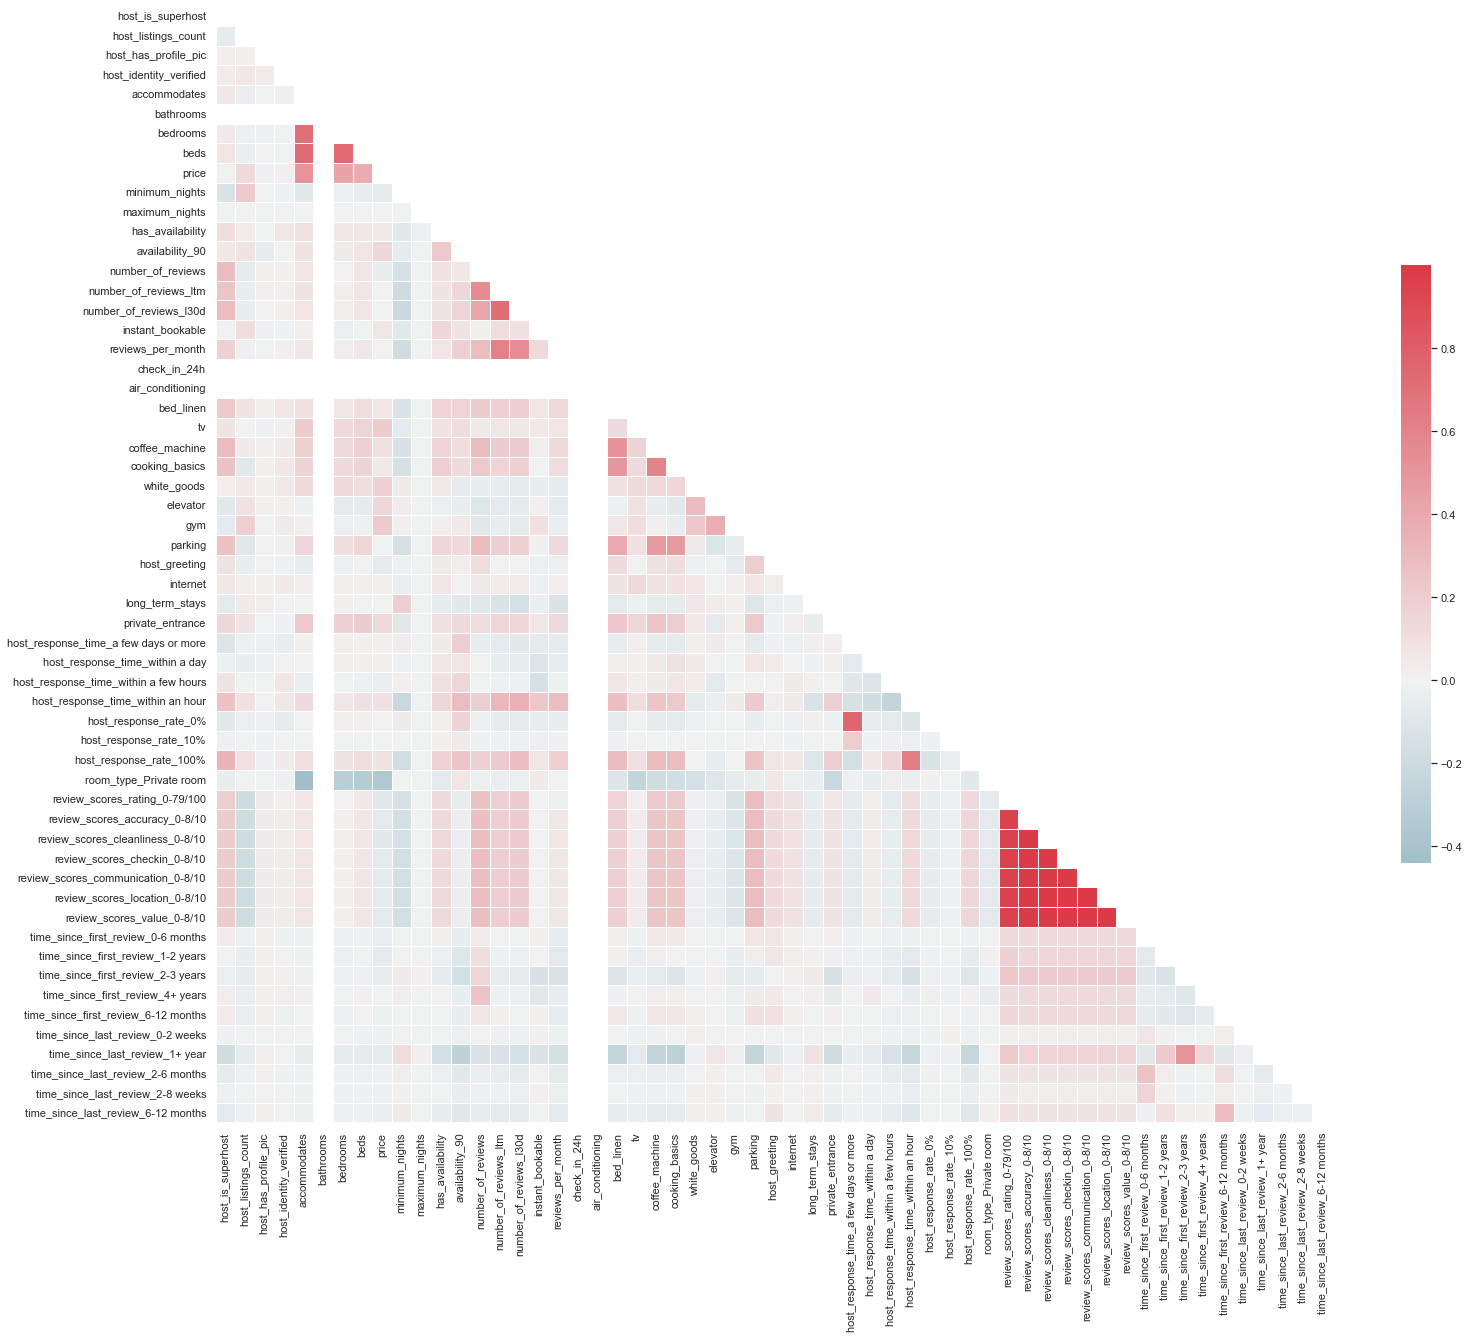

In [59]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [60]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']

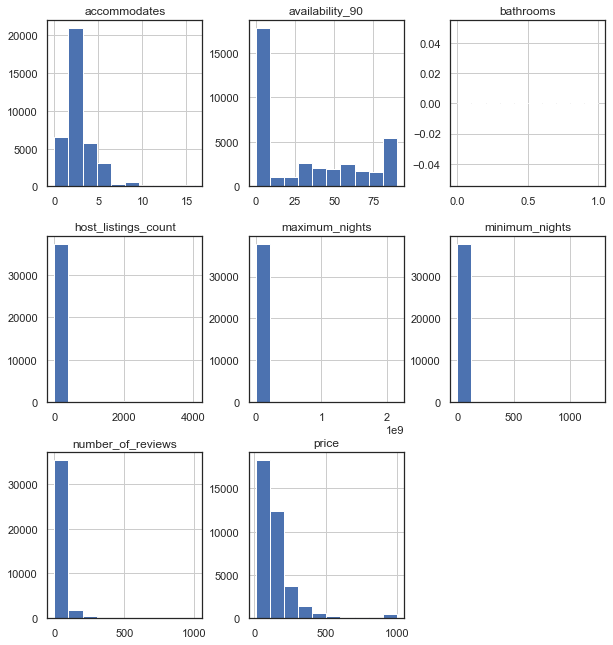

In [61]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [62]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

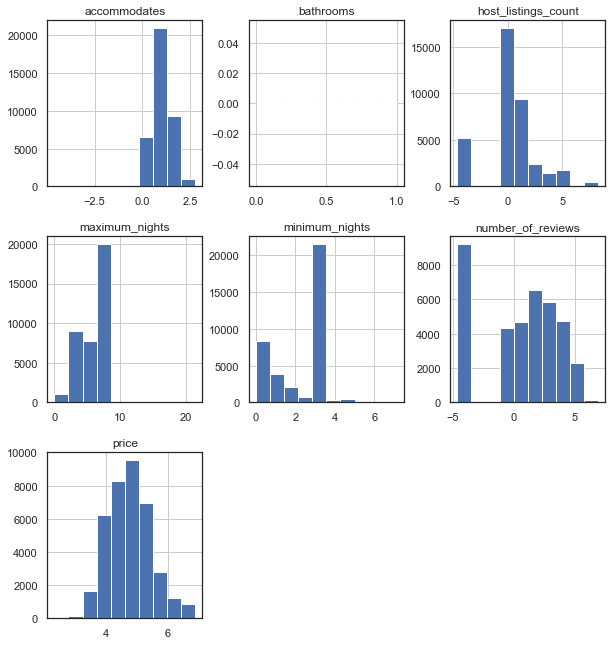

In [63]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [64]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

/usr/local/lib/python3.9/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.9/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


## Neural Network Building

In [65]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [66]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Time taken to run: 0.1 minutes

Training MSE: 0.1379
Validation MSE: 0.1981

Training r2: 0.7379
Validation r2: 0.6282


In [67]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
review_scores_communication_0-8/10,0.000000
long_term_stays,0.000000
bathrooms,0.000000
review_scores_cleanliness_0-8/10,0.000000
review_scores_value_0-8/10,0.000000
review_scores_location_0-8/10,0.000000
check_in_24h,0.000000
review_scores_checkin_0-8/10,0.000000
time_since_last_review_0-2 weeks,0.001938
number_of_reviews_l30d,0.002629


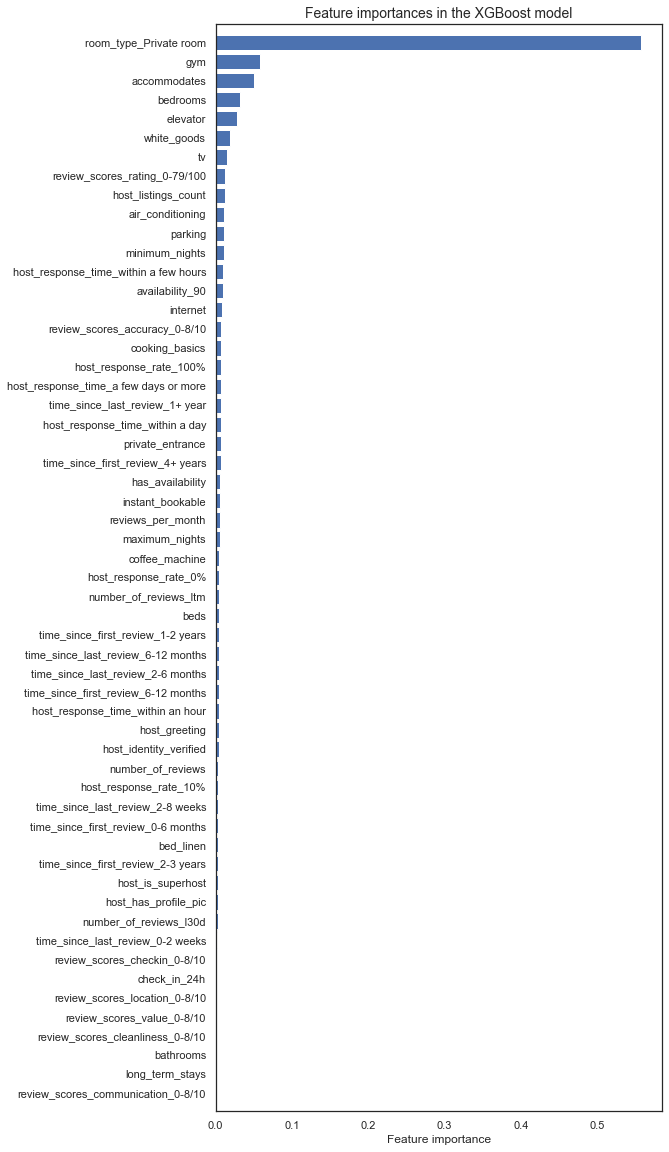

In [68]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

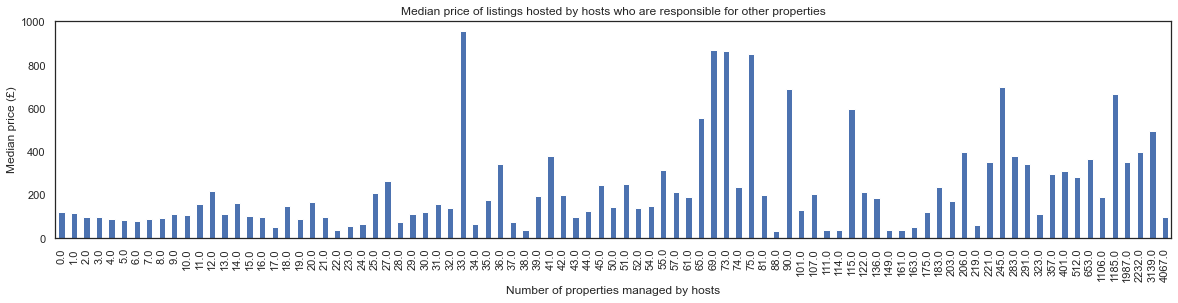

In [69]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

In [73]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               7296      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 106,369
Trainable params: 106,369
Non-trainable params: 0
_________________________________________________________________
None
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'

In [108]:
!sudo port install graphviz


sudo: a password is required
Password:
sudo: a password is required
Password:
sudo: a password is required


In [ ]:
!sudo port install graphviz

Password:

In [74]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/100
107/107 [==============================] - 1s 5ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/100
107/107 [==============================] - 0s 4ms/step - loss: nan - mean_squared_

In [103]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    # print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    # print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    # print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [104]:
nn_model_evaluation(nn2)

KeyError: 'loss'

In [102]:
model = nn2
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
# print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
# print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
# print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [81]:
np.isnan(X)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,has_availability,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,reviews_per_month,check_in_24h,air_conditioning,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,internet,long_term_stays,private_entrance,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0%,host_response_rate_10%,host_response_rate_100%,room_type_Private room,review_scores_rating_0-79/100,review_scores_accuracy_0-8/10,review_scores_cleanliness_0-8/10,review_scores_checkin_0-8/10,review_scores_communication_0-8/10,review_scores_location_0-8/10,review_scores_value_0-8/10,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37708,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37709,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37710,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [92]:
np.isnan(y_train.values.any())

False

In [82]:
np.nan_to_num(X)

array([[-0.49238321,  0.73454995,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321, -0.10733174,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321, -0.10733174,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       ...,
       [-0.49238321,  0.86347897,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321,  2.07448521,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166],
       [-0.49238321,  2.07448521,  0.08089702, ..., -0.15120885,
        -0.07002053, -0.17268166]])

In [87]:
X_train.fillna(X_train.mean())
X_test.fillna(X_test.mean())
y_test.fillna(y_test.mean())
y_train.fillna(y_train.mean())


id
41396507    4.007333
45924235    4.744932
9475136     4.499810
30396953    4.976734
568661      4.442651
              ...   
10043483    4.584967
22484057    3.555348
27677869    4.174387
45191374    4.465908
23188871    4.248495
Name: price, Length: 30170, dtype: float64